# Form factor of a two-boson bound state

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre
from scipy.special import sph_harm
from scipy.interpolate import interp1d
from functions import * #Import the functions given in the lecture  

import matplotlib.pyplot as plt


In [2]:
hbarc = 197.327 
Lambda = [300+i*100 for i in range(0, 10)]
C0 = [-9.827953*1e-2, -2.820315*1e-02,  -4.221894*1e-04, 1.285743*1e-02,
      2.016719*1e-02,  2.470795*1e-02, 2.786520*1e-02,  3.030801*1e-02,
     3.239034*1e-02,  3.431611*1e-02]
nx =20
mpi = 138
A = -0.1544435
E = -2.225/hbarc
neigv = 1
cutoff=Lambda


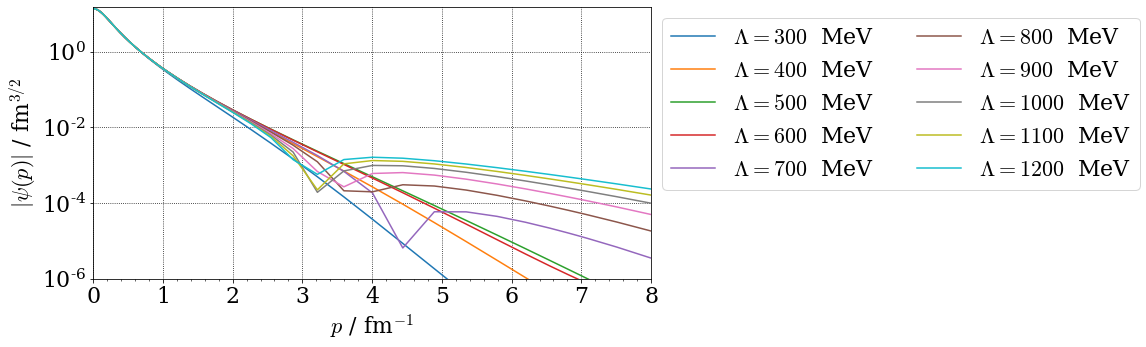

In [6]:
beauty_plot()
plt.xlim(0,8)
plt.ylim(1E-6,15)
p_list = []
weight_list=[]
psi_list = []
for i in range(len(Lambda)):
    pot = OBEpot(nx=nx,mpi=mpi,C0=C0[i],A=A,cutoff=Lambda[i])
    solver=TwoBody(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    p_list.append(solver.eigv(E, neigv)[1])
    weight_list.append(solver.pweight)
    psi_list.append(solver.eigv(E, neigv)[-1])
    plt.plot(p_list[i],np.abs(psi_list[i]), label="$\Lambda=%d$  MeV"%(Lambda[i]))
plt.yscale('log')
plt.tick_params(axis='y', which='minor')
plt.xlabel("$p$ / fm$^{-1}$")
plt.ylabel('$|\psi(p)|$ / fm$^{3/2}$')
plt.legend(bbox_to_anchor=(1,1), ncol=2)
plt.show()


In [28]:
def Formfactor(q,p,weight,wf,nx,m,n):
    x,xweight=leggauss(nx)
    theta = np.arccos(x)
    phi=0
    theta_prime = [np.arccos((p *x -1/2*q)/(np.sqrt(p**2-p*x*q+1/4*q**2))) for p in p]
    phi_prime=0 #phi = arctan(y/x)
    #sph_harm uses opposite convention for theta and phi
    angle_int=[np.sum(sph_harm(m,n,phi,theta)*sph_harm(m,n,phi,theta_prime)*xweight) for theta_prime in theta_prime] # calculate integral for each p (theta_prime)
    inter= interp1d(p, wf, kind='cubic',fill_value="extrapolate") 
    wf_inter=inter(p-1/2*q)#interpolate the wf to the grid p-1/2q
    p_int=np.sum(p**2*angle_int*wf*wf_inter*weight)
    return p_int*2*np.pi

In [46]:
nx_list=[8+2*i for i in range(10)]
f_list=[Formfactor(0,p_list[-1],weight_list[-1],psi_list[-1],nx,1,1) for nx in nx_list]
print(f_list)

[(0.9999999999999994+0j), (1.0000000000000004+0j), (0.9999999999999994+0j), (0.9999999999999991+0j), (1.0000000000000004+0j), (1.0000000000000002+0j), (0.9999999999999991+0j), (0.9999999999999971+0j), (1.0000000000000004+0j), (0.9999999999999991+0j)]
